## Imperfect Models for Stock Trades 

### Phase 1 Business Understanding

Helpful here is the five W's of WHO, WHAT, WHERE, WHEN, WHY?   

WHO's are those that want to trade stocks, for whom this project is intended to help.  
WHY they want to do that may be divine inspiration, or a quest for profit.   
WHERE this is done is in the stock market accessed by their trading acount.  
WHAT market they select seems a function of many factors.  
WHEN they do this seems significant, as price changes, buy and sell points decide profit or loss.  

Three business questions come from these considerations.  
> Can a humble stock beat the market?  
> Can an imperfect model be profitable?  
> When is the best time to buy?  

The Objective here is:  
>  to devise a stock trading model,  
>  that predicts profitable "buy" timing opportunities,  
>  using historical prices from a humble stock,  
>  which tests more profitable than the market index.  

Success criterias include:  
> a positive beat-the-market percentage.  
> some indication of an imperfect model being profitable.  
> unambiguous buy signals corresponding to the model predictions.  

Requirements, assumptions, and constraints include:  
> A modern PC running python on a Jupyter notebook.  
> Accessible finance data via Yahoo finance.  
> Open Source packages such as Numpy, Pandas, SciKitLearn.  
> An Udacity nanodegree rubric with a can-do attitude.  

Risks, Costs, and Benefits:  
> It's hard to beat the market, it probably won't work in all cases.  
> Generally speaking, spending time on educational projects is a good investment.  
> There may be some fullfilment and joy found in doing something difficult.  
> Disclaimer: trade at your own risk, as-is this is not intended for real trading.

### Phase 2 Data Understanding

#### Gather Tools

In [1]:
# data management tools
import pandas as pd
from pandas import DatetimeIndex
from pandas.plotting import table
import datetime 
from datetime import datetime, timedelta
import numpy as np
from pickle import load, dump

# data visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
sb.set()
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# data modeling tools
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

#### Manually Scrape Data

In [2]:
# Yahoo Finance Downloads to CSV files for imports
# 'https://finance.yahoo.com/quote/IBM/history'
# "https://finance.yahoo.com/quote/%5EGSPC/history"
# put these into the working directory for import

#### Import, Clean, and Preprocess Stock Data

In [3]:
def Preprocess(file):
    '''
    import downloaded csv file into pandas
    format dates and columns
    scale to adjusted close
    compute daily returns based on close to close
    return preprocessed df
    '''
    # import and format with sort ascending
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date', ascending=True)
    df = df.reset_index(drop=True)
    df = df.rename(index=str, columns={'Date':'date',
                                       'Open': 'open', 
                                       'High': 'high',
                                       'Low': 'low',
                                       'Close':'close',
                                       'Adj Close':'adj_close',
                                       'Volume':'volume',
                                       })
    
    # clean
    df = df.dropna()
    df = df.drop_duplicates()
    
    # scale
    df_scale = pd.DataFrame()
    close = df.close.to_numpy().astype(float)
    adj = df.adj_close.to_numpy().astype(float)
    scale = adj / close
    df_scale['date'] = df['date'].copy()
    df_scale['open']=df.open.to_numpy().astype(float)*scale
    df_scale['high']=df.high.to_numpy().astype(float)*scale
    df_scale['low']=df.low.to_numpy().astype(float)*scale
    df_scale['close']=df.close.to_numpy().astype(float)*scale
    df_scale['volume']=df.volume.to_numpy().astype(int)
    
    # log returns
    prices = df_scale['close']
    lookback = 1
    daily_returns = np.log(prices) - np.log(prices.shift(lookback))
    df_scale['log_ret'] = daily_returns

    return df_scale

In [4]:
def Trim(df_index, df_stock):
    '''
    import index and stock data
    get early day having returns
    trim data to earliest day and reindex
    return trimmed dataframes
    '''
    early_day = df_ibm_prp.date[1]
    
    df_idx = df_index[df_index.date >= early_day].copy()
    df_idx = df_idx.reset_index(drop=True)
    
    df_stk = df_stock[df_stock.date >= early_day].copy()
    df_stk = df_stk.reset_index(drop=True)
    
    return df_idx, df_stk

In [5]:
# Preprocess
df_spy_prp = Preprocess('GSPC.csv')
df_ibm_prp = Preprocess('IBM.csv')

# trim data to match and verify shapes
df_spy, df_ibm = Trim(df_spy_prp, df_ibm_prp)

# share some results
print('Wrangling Results:')
print('index and stock shapes:')
print(df_spy.shape, df_ibm.shape)
print('index and stock NaN counts:')
print(df_spy.isna().sum(), df_ibm.isna().sum())

Wrangling Results:
index and stock shapes:
(14810, 7) (14810, 7)
index and stock NaN counts:
date       0
open       0
high       0
low        0
close      0
volume     0
log_ret    0
dtype: int64 date       0
open       0
high       0
low        0
close      0
volume     0
log_ret    0
dtype: int64


In [6]:
# Peek at this sparkling clean data
df_ibm.head()

,date,open,high,low,close,volume,log_ret
0,1962-01-03,1.877756,1.894170,1.877756,1.894170,288000,0.008704
1,1962-01-04,1.894168,1.894168,1.874471,1.875292,256000,-0.010016
2,1962-01-05,1.872830,1.872830,1.835078,1.838361,363200,-0.019890
3,1962-01-08,1.836721,1.836721,1.789120,1.803893,544000,-0.018927
4,1962-01-09,1.812099,1.848210,1.812099,1.825230,491200,0.011759


#### Visualize

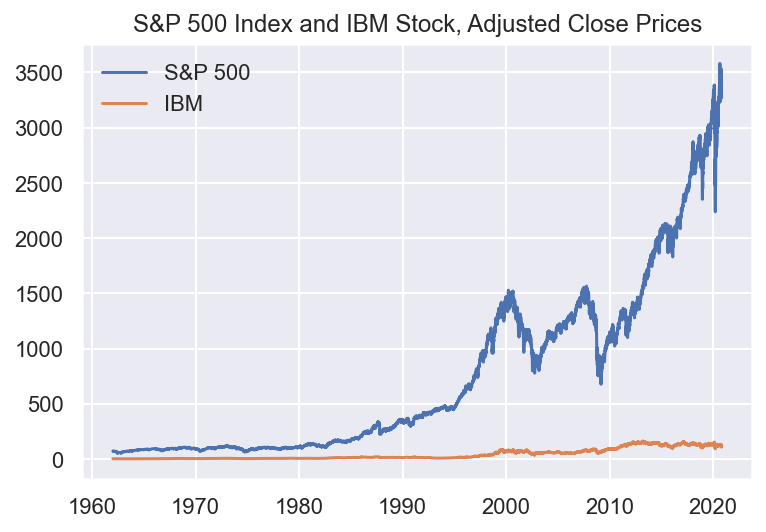

In [7]:
# Visualize the Price Data
fig = plt.figure()

dfs = [df_spy, df_ibm]
labs = ['S&P 500', 'IBM']

for frame, lab in zip(dfs, labs):
    plt.plot(frame['date'], frame['close'], label = lab)

#plt.xlim(0,18000)
#plt.ylim(0,30)
plt.title("S&P 500 Index and IBM Stock, Adjusted Close Prices")
plt.legend(loc='upper left', frameon=False)
plt.show()

#### Note: The S&P 500 Index has enormous price gains over relatively humble IBM.  

###  Can a Humble Stock Beat the Market?

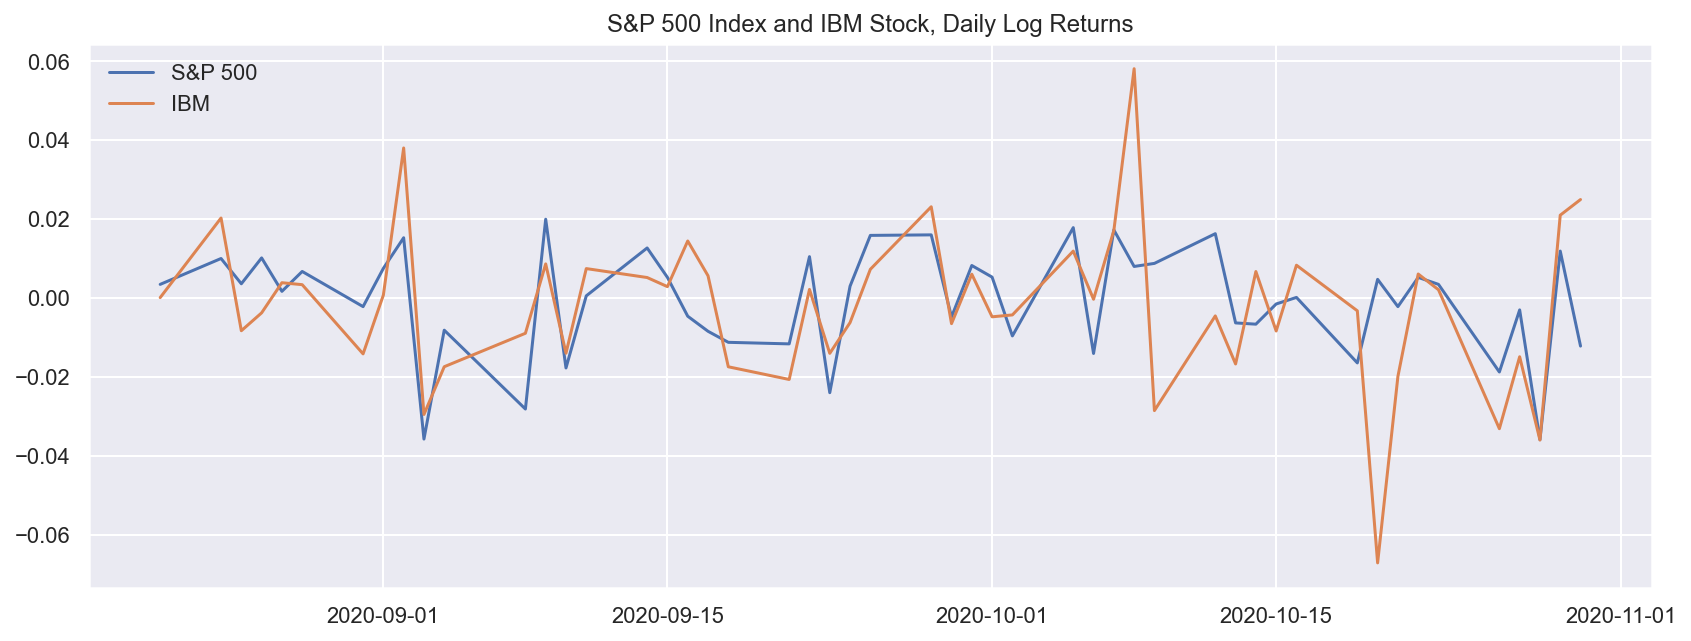

In [8]:
# Visualize some Returns Data
fig = plt.figure(figsize=(14,5))

dfs = [df_spy, df_ibm]
labs = ['S&P 500', 'IBM']

for frame, lab in zip(dfs, labs):
    plt.plot(frame['date'].tail(50), frame['log_ret'].tail(50), label = lab)

#plt.xlim(0,18000)
#plt.ylim(0,30)
plt.title("S&P 500 Index and IBM Stock, Daily Log Returns")
plt.legend(loc='upper left', frameon=False)
plt.show()

#### Note: The run chart indicates some windows of opportunity where IBM returns are higher than the S&P Index.
#### The answer is YES if timing is impecable.

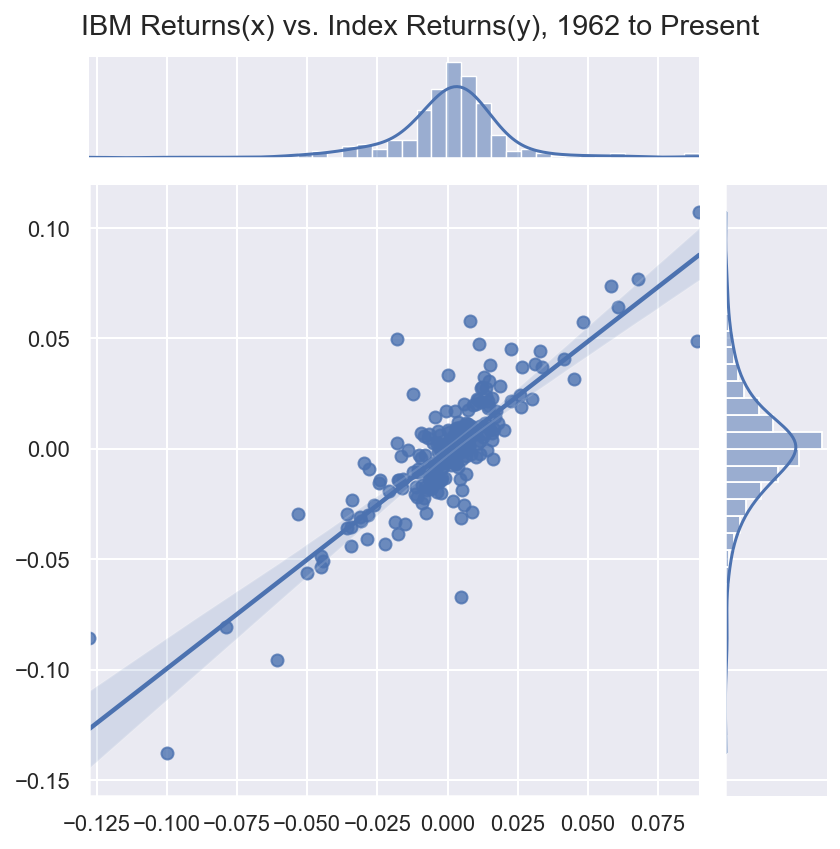

In [9]:
# Seaborn Joint Plot
spy_ret = np.asarray(df_spy.log_ret.tail(220))
ibm_ret = np.asarray(df_ibm.log_ret.tail(220))
sb.jointplot(x=spy_ret, y=ibm_ret, kind='reg')
plt.suptitle("IBM Returns(x) vs. Index Returns(y), 1962 to Present")
plt.tight_layout()
plt.subplots_adjust(top=0.93);

#### Note: The IBM Stock is positively correlated to the S&P 500 index.    
 >  The regression line for IBM is 1:1 with the index.  
 >  Along the regression line, the two returns are equal.  
 >  Below the regression line, IBM returns are relatively higher.  
 >  There seems some opportunity to beat the market given good timing.

### Phase 3 Data Preparation  

The raw data in an of itself is not enough for a model to predict near future from past.  
In this phase we "Pull History Down" onto each row, and "Pull Future Up" onto each row.  
The History information acts as model features, Future information acts as model targets.  
In this way, an imperfect model might have a chance to predict profitable buy days.

#### Build Historical Features

In [10]:
def ComputeUnitShape(prices, sigmas, dayspan):
    '''
    compute one day shape
    '''
    abs_deltas = (prices) - (prices.shift(dayspan))
    s_ratios = abs_deltas / sigmas
    ups = 3*(s_ratios>1)
    downs = 1*(s_ratios<-1)
    neuts = 2*((s_ratios>=-1)&(s_ratios<=1))      
    return (ups+downs+neuts)

In [11]:
def ComputePentaShape(unitshape, dayspan):
    '''
    import unit shape series and dayspan
    compute 5-period shape ordinals
    return penta shape series
    '''
    ago5s = 10000*(unitshape.shift(4*dayspan))
    ago4s = 1000*(unitshape.shift(3*dayspan))
    ago3s = 100*(unitshape.shift(2*dayspan))
    ago2s = 10*(unitshape.shift(1*dayspan))
    return (ago5s+ago4s+ago3s+ago2s+unitshape)

In [12]:
def BuildFeatures(df):
    '''
    import preprocessed market df
    compute statistics 
    use unit shape spans of 1, 3, 5, 7, 9 days
    build penta shape ordinals from unit shapes
    return augmented df
    '''
    df_for = df.copy()
    
    # raw data overlaps
    shifts = [['o1','h1','l1','c1'],
              ['o2','h2','l2','c2'],
              ['o3','h3','l3','c3'],
              ['o4','h4','l4','c4'],
              ['o5','h5','l5','c5'],
              ['o6','h6','l6','c6'],
              ['o7','h7','l7','c7'],
              ['o8','h8','l8','c8'],
             ]
    # format df to calculate price estimates and standard deviations
    # shift old figures up to current
    for j, shift in zip(range(1,9),shifts):
        df_for[shift[0]] = df_for.open.shift(j)
        df_for[shift[1]] = df_for.high.shift(j)
        df_for[shift[2]] = df_for.low.shift(j)
        df_for[shift[3]] = df_for.close.shift(j)

    # define price estimate columns for 1,3,5,7,9 past day spans
    p1_col = df_for.loc[:,"open":"close"].astype(float)
    p3_col = df_for.loc[:,"open":"c2"].astype(float)
    p5_col = df_for.loc[:,"open":"c4"].astype(float)
    p7_col = df_for.loc[:,"open":"c6"].astype(float)
    p9_col = df_for.loc[:,"open":"c8"].astype(float)
    p_cols = [p1_col, p3_col, p5_col, p7_col, p9_col]

    # compute price estimates and standard deviations for spans
    stats = [['pe1','sd1'],['pe3','sd3'],['pe5','sd5'],
             ['pe7','sd7'],['pe9','sd9']]
    for stat, p_col in zip(stats, p_cols):
        df_for[stat[0]] = p_col.mean(axis=1)
        df_for[stat[1]] = p_col.std(axis=1)

    # leave some raw data behind
    df_prep = df_for[['date','open','high','low','close','volume',
                      'log_ret','pe1','sd1','pe3','sd3','pe5','sd5',
                      'pe7','sd7','pe9','sd9']].copy()
    
    # add lookback unit shapes to df
    unitshapes = ['ds1','ds3','ds5','ds7','ds9']
    dayspans = [1,3,5,7,9]
    for shape, stat, span in zip(unitshapes, stats, dayspans):
        df_prep[shape] = ComputeUnitShape(df_prep[stat[0]], 
                                          df_prep[stat[1]], span)
        
    # add lookback penta shapes to df
    shapes = ['shp1','shp3','shp5','shp7','shp9']
    for shape, unitshape, span in zip(shapes, unitshapes, dayspans):
        df_prep[shape] = ComputePentaShape(df_prep[unitshape], span)

    #trim the head and tail NaN's off then format
    # note that five lookbacks of span nine is 45 day rows on the head
    # note that seven look aheads of span one is 7 day rows on the tail
    df_trim = df_prep[45:].copy()
    df_trim[['shp1','shp3','shp5','shp7','shp9']] = \
    df_trim[['shp1','shp3','shp5','shp7','shp9']].astype(int)
    
    return df_trim

In [13]:
df_mkt_feat = BuildFeatures(df_ibm)
df_mkt_feat.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'log_ret', 'pe1',
       'sd1', 'pe3', 'sd3', 'pe5', 'sd5', 'pe7', 'sd7', 'pe9', 'sd9', 'ds1',
       'ds3', 'ds5', 'ds7', 'ds9', 'shp1', 'shp3', 'shp5', 'shp7', 'shp9'],
      dtype='object')

####  Historical features include:  
> single day log returns.  
> 1,3,5,7,9 day price moving averages and corresponding standard deviations.  
> 1,2,5,7,9 day unit shape and penta-shape ordinals.

#### Build Model Targets

In [14]:
def ComputeProj(returns, lookahead):
    '''
    input log returns
    compute projected future lookahead returns
    signal day is a non-buy day
    day after signal day is a buy day
    two days after signal day is the first return
    lookahead day is the sell day and last return day
    assume sell point on lookahead day is at the close
    return projected log returns
    '''
    roll_sum = returns.rolling(lookahead - 1).sum()
    proj_ret = roll_sum.shift(periods=-lookahead)
    return proj_ret

In [15]:
def BuildTargets(df_feat):
    '''
    import feature augmented data
    compute projected lookahead returns
    split projected returns into septiles
    categorize septile bins
    assign top septile as a buy target of 1
    return target augmented df
    return df for visualizing septiles
    '''
    df_trg = df_feat.copy()
    # compute projections
    lookahead_days = 7
    aheads = ComputeProj(df_trg['log_ret'], lookahead_days)
    # add to collection for evaluation purposes
    df_trg['proj'] = aheads
    # assign septile categories based on trade returns
    trade_cats = pd.qcut(aheads,7, labels=[1,2,3,4,5,6,7])
    # add target category as residing within top septile
    df_trg['target'] = ((trade_cats==7))*1
    # build visualization df
    df_vis = pd.DataFrame({'opcat':trade_cats,
                           'proj': aheads,
                           'price':df_trg['pe1']})
    return df_trg, df_vis

In [16]:
df_mkt_trg, df_tv = BuildTargets(df_mkt_feat)
df_mkt_trg.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'log_ret', 'pe1',
       'sd1', 'pe3', 'sd3', 'pe5', 'sd5', 'pe7', 'sd7', 'pe9', 'sd9', 'ds1',
       'ds3', 'ds5', 'ds7', 'ds9', 'shp1', 'shp3', 'shp5', 'shp7', 'shp9',
       'proj', 'target'],
      dtype='object')

####  Model Targets:  
> 1's are the buy days.  
  the model predicts these for buying purposes,  
  with the best intent of being profitable  
  which may or may not be the case.

> 0's are the non-buy days.  
  the model predicts these for abstaining purposes.

#### Visualizing Profit  

### When is the best time to buy?

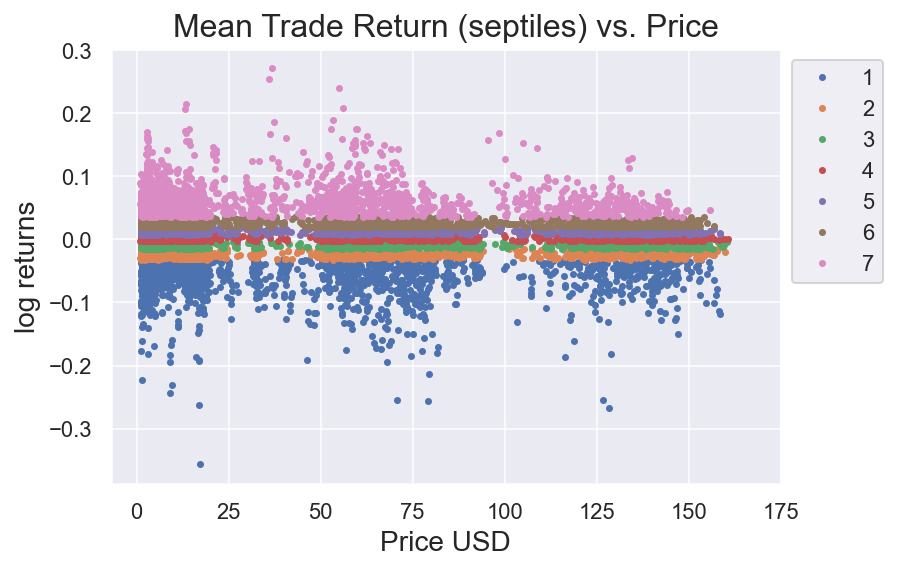

In [17]:
# Septile Plot of Mean Trade Returns
groups = df_tv.groupby('opcat')
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.price, group.proj, marker='.', 
            linestyle='', ms=5, label=name)
ax.legend()
#plt.xlim(0, 200)
#plt.ylim(-0.2,0.2)
plt.title('Mean Trade Return (septiles) vs. Price',fontsize=16)
plt.xlabel('Price USD',fontsize=14)
plt.ylabel('log returns',fontsize=14)
plt.xticks(np.arange(0, 200, step=25))
plt.grid(alpha=0.75)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()

### The best time to buy are when the Future Returns are in the Upper Septile (Pink Area above.)  
###  These buy days shall be predicted as 1's, by our yet-to-be prediction model.

In [18]:
# Verify "1" Targets are ~1/7 of the data
# Note the span of this data is ~60 years
len(df_mkt_trg),len(df_mkt_trg[df_mkt_trg['target']==1])

(14765, 2109)

#### One Hot Encode Ordinals  
This specialized step promotes high quality machine learning models

In [19]:
def OneHot(df):
    '''
    input data with ordinal features
    one hot encode ordinals
    return encoded data
    '''
    df_mkt = df.copy()
    # One-Hot encode the non-numerical categorical variables
    cat_vars = ['ds1', 'ds3', 'ds5', 'ds7', 'ds9', 
                'shp1', 'shp3', 'shp5', 'shp7', 'shp9']
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df_mkt = pd.concat([df_mkt.drop(var, axis=1), 
                            pd.get_dummies(df_mkt[var], 
                                           prefix=var, 
                                           prefix_sep='_', 
                                           drop_first=True)], axis=1)
    return df_mkt   

In [20]:
# Convert Ordinal Features
df_mkt = OneHot(df_mkt_trg)
print('Number of training features = ', len(df_mkt.columns)-3)

Number of training features =  277


#### Test Train Split  
Finance data is specially handled so that only past data is used for future prediction.  
The Train, Test, and Validation sets are sequential blocks of data in time.  
As such, a specialized function is used to manage this.  

In [21]:
def test_train_split(df_mkt, val_year, num_ty):
    '''
    input market data, validation year, and number of train years
    split preprocessed data into train, test, and validation dataframes
    validation year comes after test year
    test year comes after years of train data
    return train, test, and validation dataframes
    '''
    df = df_mkt.copy()
    years = df.date.map(lambda x: x.strftime('%Y')).astype(int)
    
    #train = years < test_year for 3 years behind
    test_year = val_year - 1
    train = ((test_year-num_ty <= years) & (years < test_year))
    test = np.isin(years, test_year)
    val = np.isin(years, val_year)

    df_train = df[train].copy()
    df_test = df[test].copy()
    df_val = df[val].copy()
    
    return df_train, df_test, df_val

In [22]:
# Split  5 years previous to the testing year
val_year = 2020
year_prev = 5
df_train, df_test, df_val = test_train_split(df_mkt, val_year, year_prev)

In [23]:
# Train set size and Buy Targets
len(df_train),len(df_train[df_train['target']==1])

(1258, 107)

In [24]:
# Test set and Buy Targets
len(df_test),len(df_test[df_test['target']==1])

(252, 27)

In [25]:
# Validation set and Buy Targets
len(df_val),len(df_val[df_val['target']==1])

(211, 44)

#### Note the septiles were built on ~60 years of data and splits are not stratified as timewise varying.   
There's good years and not so great years.  Good years have more "1" buys days.  
The train data needs enough span to learn historical price patterns.  
(Instead of a septile threshold, a training data hyperparameter optimized threshold could be used.)

In [26]:
# Training Feature Set
cols = list(df_mkt.columns )
not_features = ['date','proj', 'target']
features = [f for f in cols if f not in not_features]

In [27]:
# Train and Test
X_train = df_train[features]
y_train = df_train['target']
X_test = df_test[features]
y_test = df_test['target']
X_val = df_val[features]
y_val = df_val['target']

In [28]:
# Scale the Numerical Variables using scaler fit on the train data
ss= StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
X_val_scaled = ss.transform(X_val)
y_train = np.array(y_train)

We balance the train set for equal 1's and 0's using SMOTE.

In [29]:
# Augment with Simulated Data to Balance Train Dataset
X_train_resamp, y_train_resamp = SMOTE(k_neighbors=5, random_state=19).fit_resample(X_train_scaled, y_train)

In [30]:
# Verify Train Set Target balance
len(X_train_resamp),sum(y_train_resamp>0)

(2302, 1151)

### Phase 4 Modeling 

#### Classification Model  
A random forest model is chosen for the purpose of general prediction.  
Becuase the intent is an imperfect model as profitable, a good predictor is enough. 

In [31]:
# Invoke and Train Random Forest
rfc = RandomForestClassifier(random_state=10, n_estimators=300)
rfc.fit(X_train_resamp, y_train_resamp)

RandomForestClassifier(n_estimators=300, random_state=10)

In [32]:
# Model Performance
y_pred = rfc.predict(X_test_scaled)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       225
           1       0.09      0.07      0.08        27

    accuracy                           0.82       252
   macro avg       0.49      0.49      0.49       252
weighted avg       0.81      0.82      0.81       252



In [33]:
# Mean Accuracy
rfc.score(X_test_scaled,y_test)

0.8214285714285714

#### Threshold Tuning for Random Forest
To eek out as much performance as possible, we attempt threshold tuning.  
This is a specialized modeling step.

In [34]:
def Thresh(X_data, model, thresh):
    '''
    import X_data, model, and threshold value
    return predictions after thresholding
    '''
    m_pred = model.predict_proba(X_data)[:,1]
    t_pred = [1 if (prob >= thresh) else 0 for prob in m_pred]
    return t_pred

#### Visualize Model Classification Performance

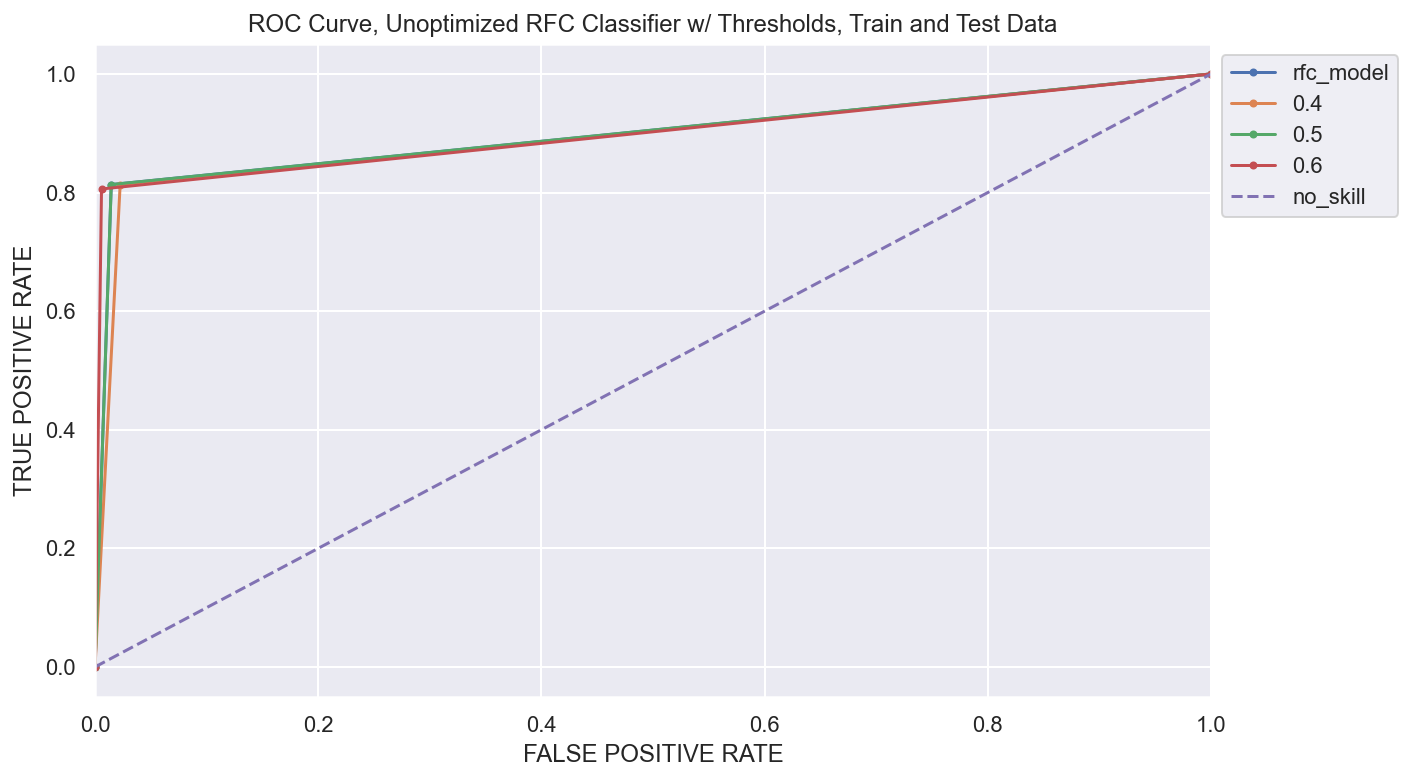

In [36]:
#ROC Curves for train and test data
tf = pd.concat([df_train,df_test],axis = 0, ignore_index=True)
tf[features] = ss.transform(tf[features])
m_pred = rfc.predict(tf[features])
c_fpr, c_tpr, _ = roc_curve(tf['target'], m_pred)
t_trys = [0.4,0.5,0.6]
plt.figure(figsize= (10,6))
plt.xlim(0,1)
plt.plot(c_fpr,c_tpr, marker='.',label='rfc_model')
for t in t_trys:
    t_pred = Thresh(tf[features],rfc,t)
    fpr, tpr, _ = roc_curve(tf['target'], t_pred)
    plt.plot(fpr, tpr, marker='.', label=str(t))

plt.plot([0,1], [0,1], linestyle='--', label='no_skill')
plt.xlabel('FALSE POSITIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')

plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.title('ROC Curve, Unoptimized RFC Classifier w/ Thresholds, Train and Test Data')
plt.show()

Note: the Threshold Tuning tweaks classifications of Train set  
> for example if a future row was a clone of the train set, we'd want it to perform well.  
> this relates to visualizing the ROC with both train and test cases.  
> the out of box classifier seems near optimal at the 0.5 threshold.  

In [37]:
# Threshold Tuning on Test Set
threshold = 0.5
t_pred = Thresh(X_test_scaled, rfc, threshold)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       225
           1       0.09      0.07      0.08        27

    accuracy                           0.82       252
   macro avg       0.49      0.49      0.49       252
weighted avg       0.81      0.82      0.81       252



The imperfections in the model are revealed - it is less than a pefect classifier.  
However it has not been optimized yet, it may be improved.  

In [38]:
def plot_confusion_matrix(y_true, y_pred, title):
    '''
    import true and predicted
    plot confustion matrix
    '''
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns, index=index)
    sb.heatmap(table, annot=True, fmt='d',cmap='viridis')
    plt.title(title,fontsize=16)

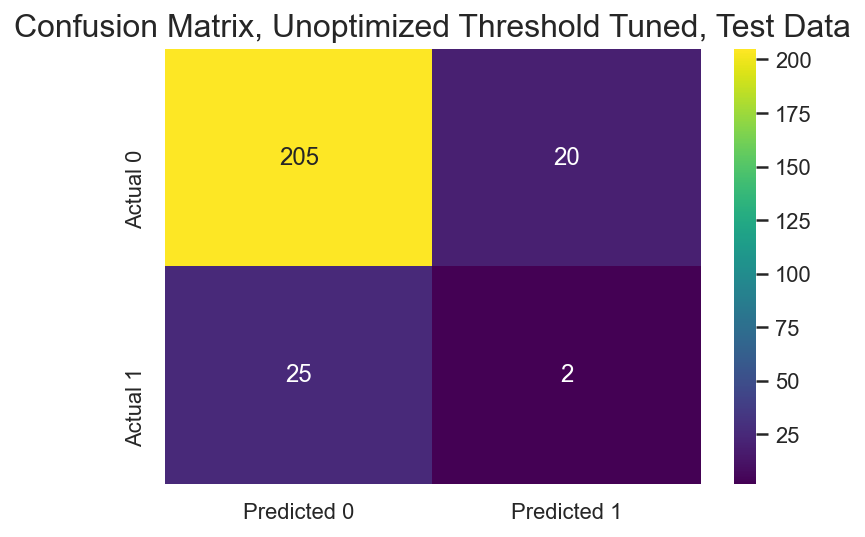

In [39]:
plot_confusion_matrix(y_test,t_pred, 'Confusion Matrix, Unoptimized Threshold Tuned, Test Data')

As made apparent by the confusion matrix:  
most of the best buy days are predicted as non-buy days,  
and many non-buy days predicted as buy days.

### Can an imperfect model be profitable?

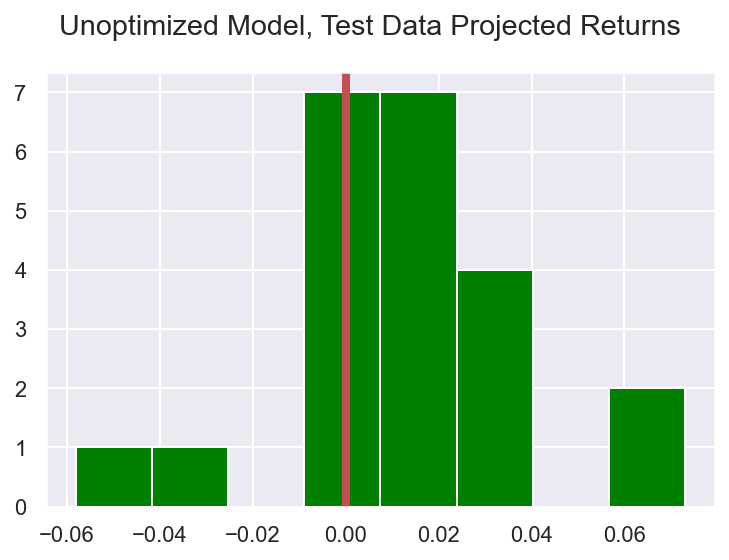

In [40]:
# Plot Classifier Projected Returns
mask = np.asarray(t_pred)
returns = df_test['proj'].where(mask>0).dropna()
returns.hist(bins=8, color='green')
plt.axvline(x=0, linewidth=4, color='r')
plt.suptitle('Unoptimized Model, Test Data Projected Returns');

#### Yes, this imperfect model was tested as profitable on the whole, where profits outweigh losses. 
It was not perfectly profitable in every case, but profitable more times than not.

In [41]:
#expected returns over range in percent
exp_ret = (np.exp(returns.T.sum())-1)*100
exp_ret

31.482736222300645

In [42]:
# Number of positive return trades, and not
np.sum(returns>0), np.sum(returns<0)

(18, 4)

#### Optimize Model Hyperparameters  
This is another specialized step to eek out as much performance as possible.

In [43]:
# Make a Base Model
forest = RandomForestClassifier(random_state = 1)
modelF = forest.fit(X_train_resamp, y_train_resamp)
forest.score(X_test_scaled,y_test)

0.8214285714285714

In [44]:
# Set-up a Hyperparameter Grid and Crunch
n_estimators = [100, 150, 200, 300]
max_depth = [12, 25, 50, 75]
min_samples_split = [2, 3, 5, 10]
min_samples_leaf = [1, 2, 3, 5] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 2, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train_resamp, y_train_resamp)

Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  2.5min finished


In [45]:
# Best Model Hyperparameters
bestF.best_params_

{'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [46]:
# Best Imperfect Model mean accuracy on train data
bestF.best_score_

0.8301476976542137

In [47]:
# Best Imperfect Model on test data
be = bestF.best_estimator_
be.score(X_test_scaled,y_test)

0.8214285714285714

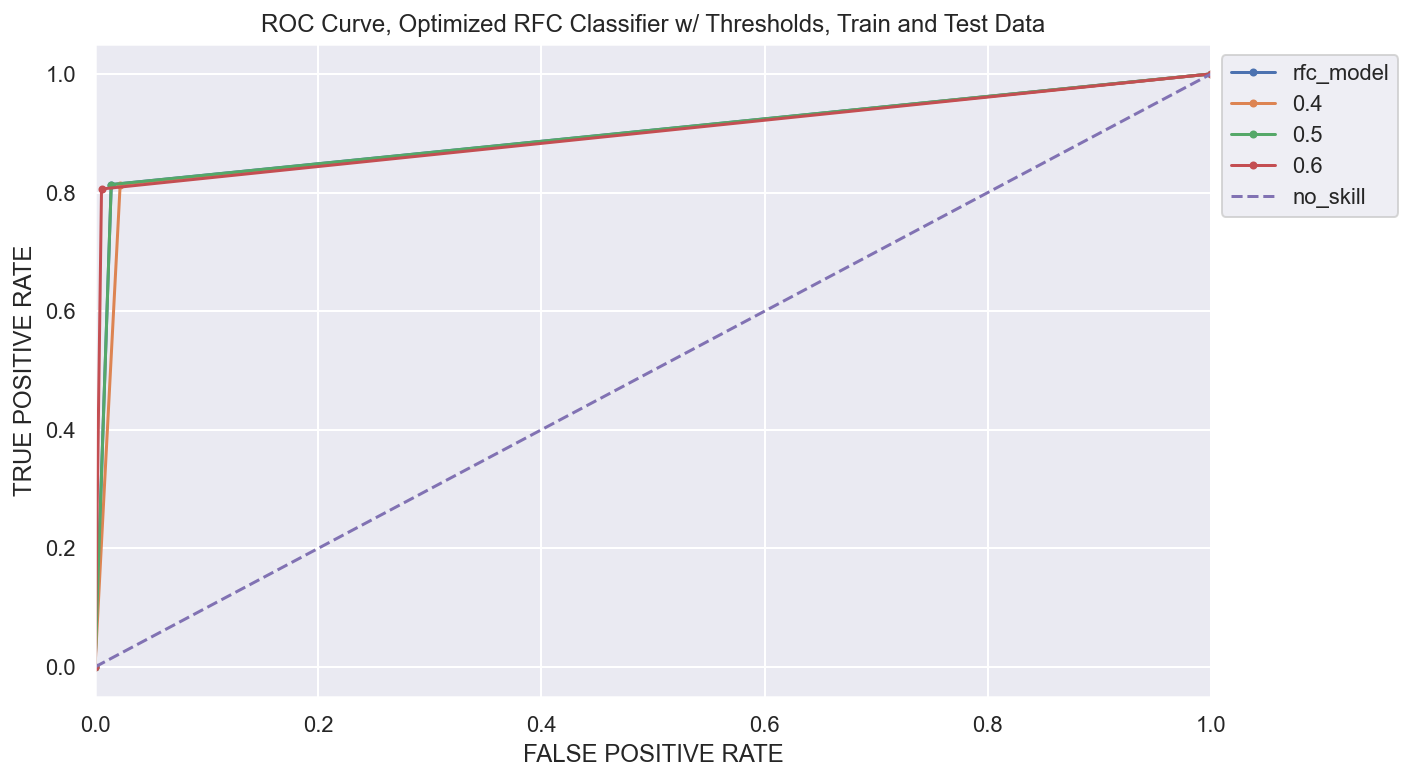

In [48]:
#ROC Curves on train and test data
m_pred = be.predict(tf[features])
c_fpr, c_tpr, _ = roc_curve(tf['target'], m_pred)
t_trys = [0.4,0.5,0.6]
plt.figure(figsize= (10,6))
plt.xlim(0,1)
plt.plot(c_fpr,c_tpr, marker='.',label='rfc_model')
for t in t_trys:
    t_pred = Thresh(tf[features],rfc,t)
    fpr, tpr, _ = roc_curve(tf['target'], t_pred)
    plt.plot(fpr, tpr, marker='.', label=str(t))
plt.plot([0,1], [0,1], linestyle='--', label='no_skill')
plt.xlabel('FALSE POSITIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.title('ROC Curve, Optimized RFC Classifier w/ Thresholds, Train and Test Data')
plt.show()

The optimized model performance looks very similar to the out of box model.

In [49]:
# threshold tuning
threshold = 0.5
t_pred = Thresh(X_test_scaled, be, threshold)
print(classification_report(y_test,t_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       225
           1       0.09      0.07      0.08        27

    accuracy                           0.82       252
   macro avg       0.49      0.49      0.49       252
weighted avg       0.81      0.82      0.81       252



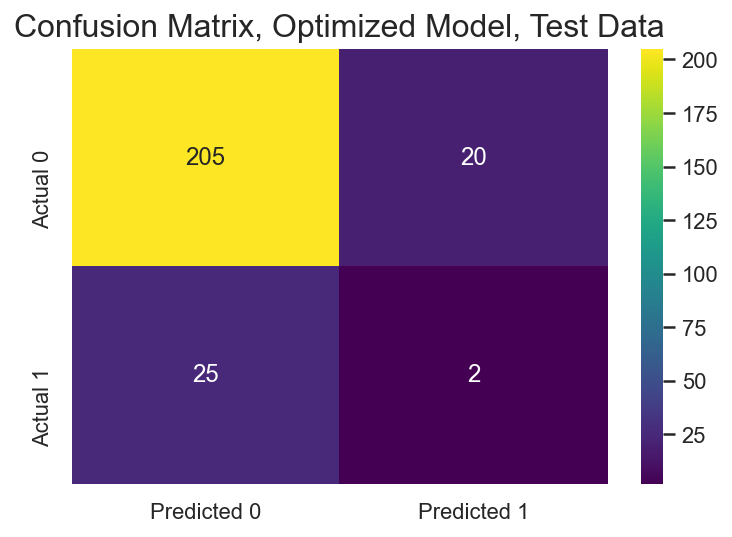

In [50]:
plot_confusion_matrix(y_test,t_pred,'Confusion Matrix, Optimized Model, Test Data')

The confusion matrix result looks similar for optimized and unoptimized cases.

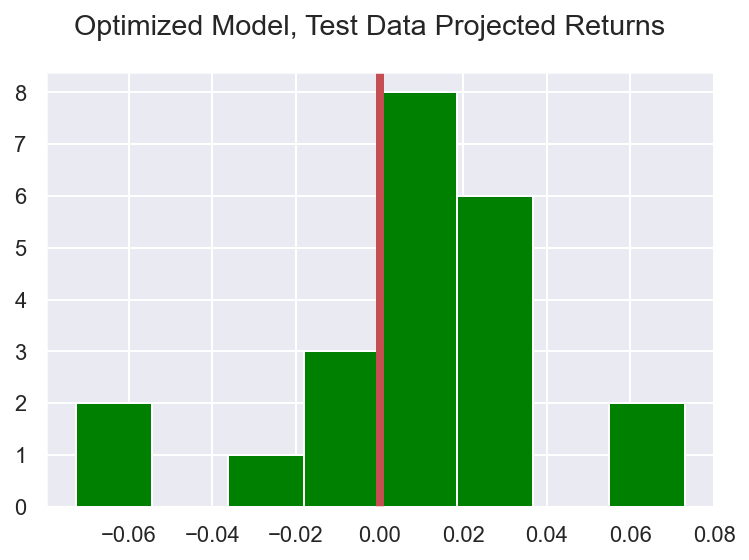

In [51]:
mask = np.asarray(t_pred)
returns = df_test['proj'].where(mask>0).dropna()
returns.hist(bins=8, color= 'green')
plt.axvline(x=0, linewidth=4, color='r')
plt.suptitle('Optimized Model, Test Data Projected Returns');

For the optimized model, the positive profits still weigh heavier than losses.

In [52]:
#expected returns over range in percent
exp_ret = (np.exp(returns.T.sum())-1)*100
exp_ret

19.822227401543046

In [53]:
# Number of positive return trades, and not
np.sum(returns>0), np.sum(returns<0)

(16, 6)

The model optimization seems to have reduced profit slightly on the test data.

### Phase 5 Evaluation

#### Validation Performance

In [54]:
# threshold tuned predictions using optimized model on validation data
threshold = 0.5
tv_pred = Thresh(X_val_scaled, be, threshold)
print(classification_report(y_val,tv_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       167
           1       0.39      0.32      0.35        44

    accuracy                           0.75       211
   macro avg       0.61      0.59      0.60       211
weighted avg       0.74      0.75      0.74       211



The performance on never-before-seen validation data seems acceptable.

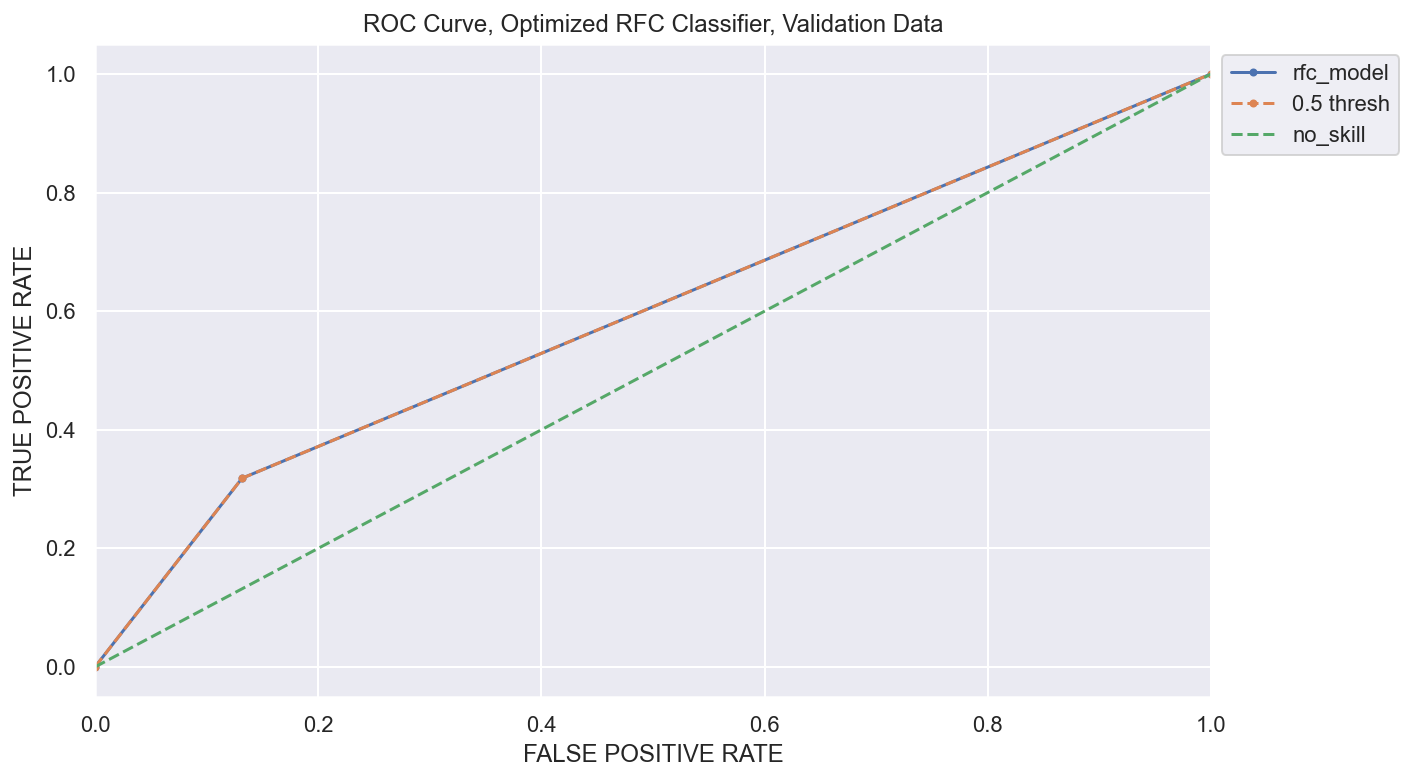

In [55]:
#ROC Curves on validation data
plt.figure(figsize= (10,6))
plt.xlim(0,1)
m_pred = be.predict(X_val_scaled)
m_fpr, m_tpr, _ = roc_curve(y_val, m_pred)
plt.plot(m_fpr,m_tpr, marker='.',label='rfc_model')
t_fpr, t_tpr, _ = roc_curve(y_val, tv_pred)
plt.plot(t_fpr,t_tpr, marker='.',label='0.5 thresh',linestyle='--')
plt.plot([0,1], [0,1], linestyle='--', label='no_skill')
plt.xlabel('FALSE POSITIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.title('ROC Curve, Optimized RFC Classifier, Validation Data')
plt.show()

As seen before the optimal threshold and bare model agree, though the classification seems imperfect.

In [56]:
# threshold tuning
threshold = 0.5
tv_pred = Thresh(X_val_scaled, be, threshold)
print(classification_report(y_val,tv_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       167
           1       0.39      0.32      0.35        44

    accuracy                           0.75       211
   macro avg       0.61      0.59      0.60       211
weighted avg       0.74      0.75      0.74       211



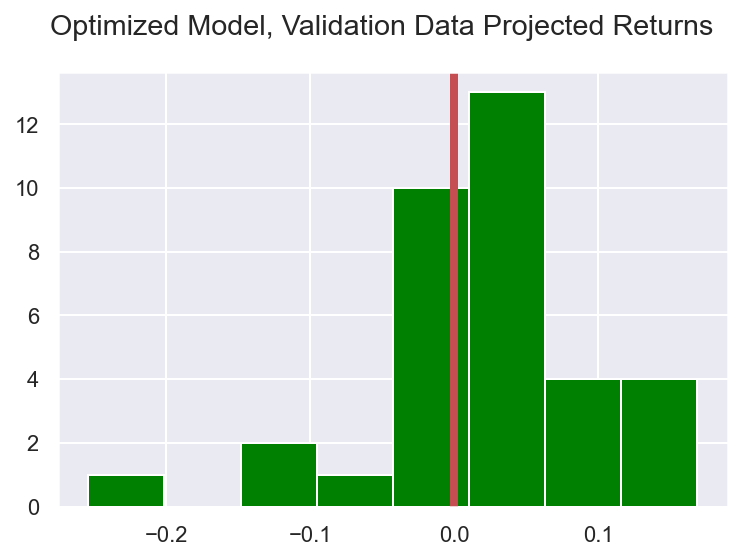

In [57]:
mask = np.asarray(tv_pred)
returns = df_val['proj'].where(mask>0).dropna()
returns.hist(bins=8, color= 'green')
plt.axvline(x=0, linewidth=4, color='r')
plt.suptitle('Optimized Model, Validation Data Projected Returns');

The validation performance weighs positive as expected.
#### The imperfect model as profitable meets the success criteria.

In [58]:
#expected returns over range in percent
exp_ret = (np.exp(returns.T.sum())-1)*100
exp_ret

120.4854738723109

In [59]:
# Number of positive return trades, and not
np.sum(returns>0), np.sum(returns<0)

(25, 10)

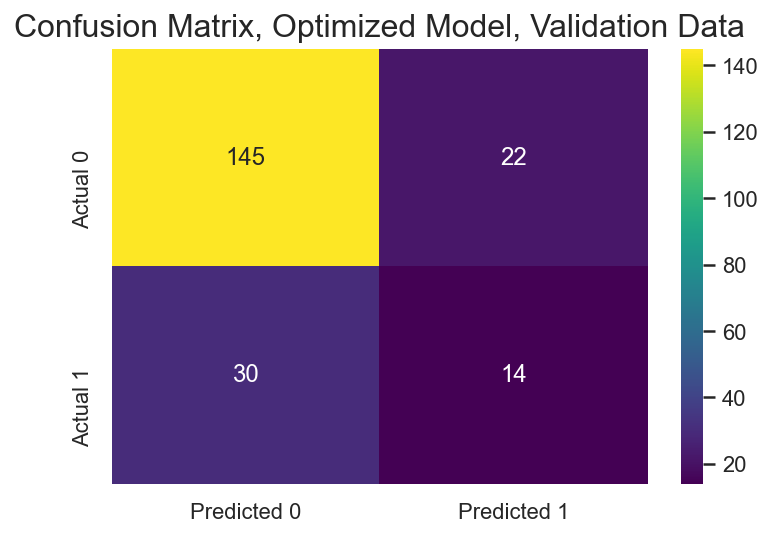

In [60]:
plot_confusion_matrix(y_val,tv_pred,'Confusion Matrix, Optimized Model, Validation Data')

The confusion matrix reveals many buy days found in 2020.

#### Beat the Market Comparison  
We look at how the market did in the similar trading days.

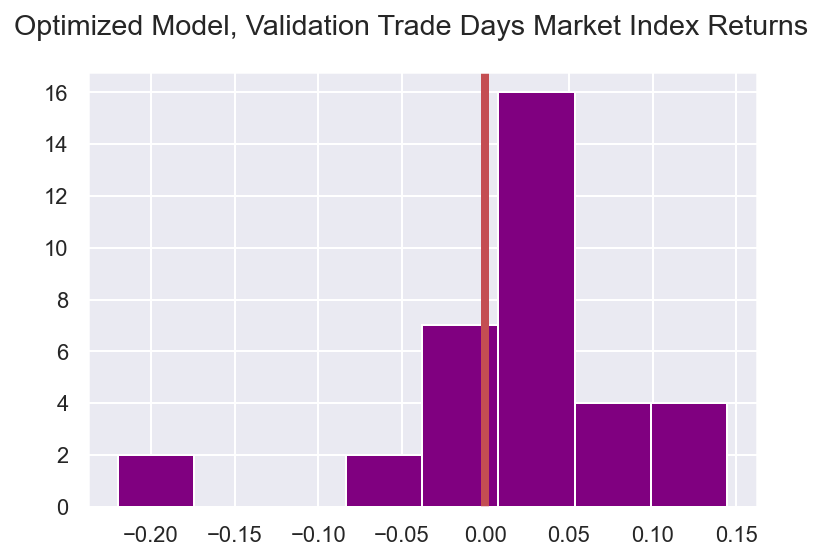

In [61]:
# add projections to index
lookahead_days = 7
aheads = ComputeProj(df_spy['log_ret'], lookahead_days)
df_spy['proj'] = aheads
# market data for test days
df_spy_val = df_spy[df_spy.index.isin(df_val.index)]
# index returns for same days as IBM validation trades
spy_returns = df_spy_val['proj'].where(mask>0).dropna()
# plot histogram
spy_returns.hist(bins=8, color= 'purple')
plt.axvline(x=0, linewidth=4, color='r')
plt.suptitle('Optimized Model, Validation Trade Days Market Index Returns');

The model's buy days likewise weigh profitable in the market.

In [62]:
# S&P 500 Index return on similar trading days
spy_exp_ret = (np.exp(spy_returns.T.sum())-1)*100
spy_exp_ret

77.92355829945296

#### A humble stock shown to beat the market meets the success criteria.

In [63]:
# Beat the Market Percentage
exp_ret - spy_exp_ret

42.56191557285794

In [64]:
#annualized volatility
vol_year = np.std(returns)*np.sqrt(252)
vol_year

1.2696368860467422

This returns volatility is extremly high, about 10x recommended.  
It's due to a low number of trades with non-normal distribution.

In [65]:
# compute years for sharpe
df_t = df_val.reset_index(drop=True)
years = np.asscalar((df_t['date'].tail(1)-df_t['date'][0])/timedelta(days=365))
years

0.8273972602739726

In [66]:
# sharpe ratio on this trade strategy based on 1 year bond rate
# note returns are not normal distribution so figure may be misleading
ret_year = (np.exp(returns.T.sum())-1)/years
risk_free = 0.0012
sharpe = (ret_year - risk_free) / vol_year
sharpe

1.1459958544444968

The Sharpe ratio is acceptable as >1.

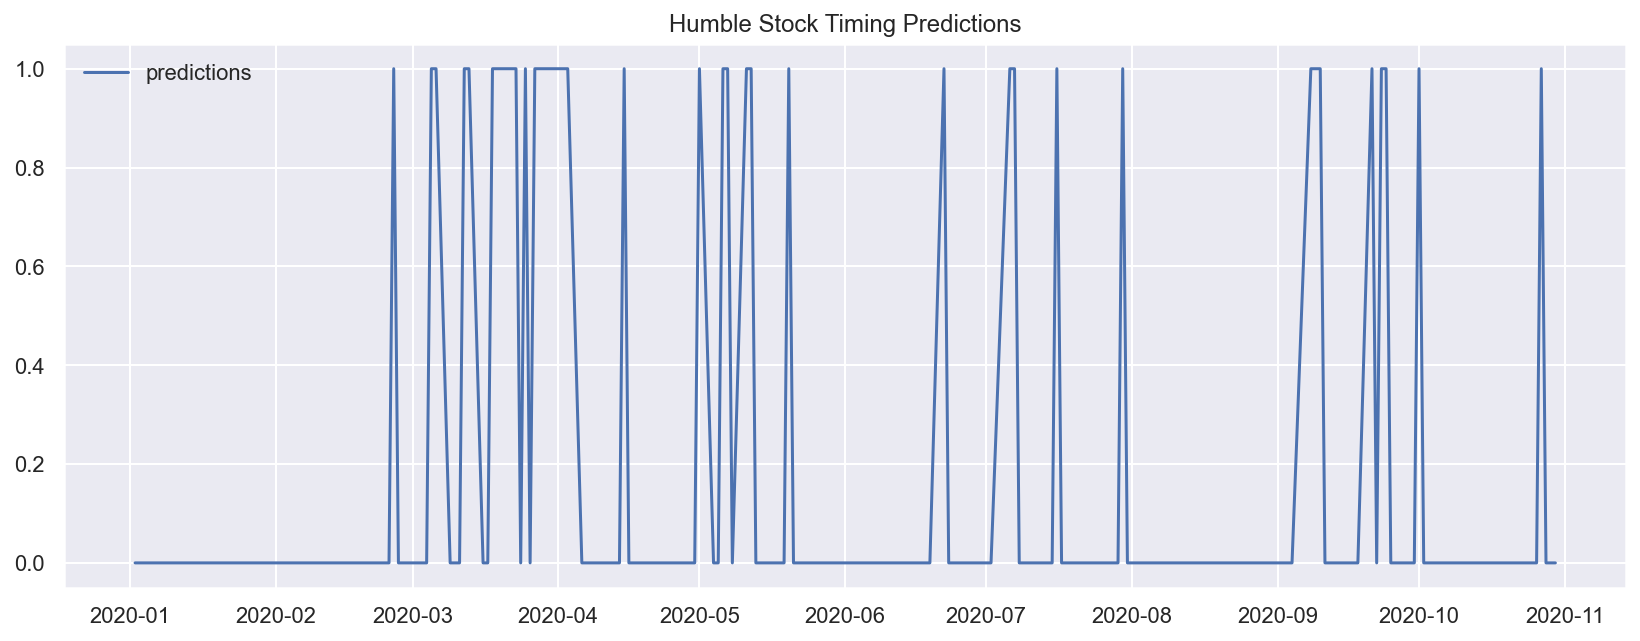

In [67]:
# Visualize the Buy Signals
fig = plt.figure(figsize=(14,5))
plt.plot(df_val['date'], tv_pred, label = 'predictions')
plt.title("Humble Stock Timing Predictions")
plt.legend(loc='upper left', frameon=False)
plt.show()

#### Unambiguous signals indicating when to buy, meets the success criterion.

### Phase 6 Deployment
Here we save model artifacts for use later.  
We also run the data end to end,   
from starting raw data to finished predictions.  
We verify the result is the same as expected.  
Then load it into a script that does the same thing.  
Then test the script result is similar.  


In [68]:
# Save the train data

# save the features
dump(features, open('feature.pkl', 'wb'))
# save the model
dump(be, open('model.pkl', 'wb'))
# save the scaler
dump(ss, open('scaler.pkl', 'wb'))

In [69]:
def Pipe(file):
    '''
    import file
    run data through a pipeline process
    augment predictions
    return df with buy predictions
    '''
    # load the model
    feat = load(open('feature.pkl', 'rb'))
    # load the model
    mod = load(open('model.pkl', 'rb'))
    # load the scaler
    scl = load(open('scaler.pkl', 'rb'))
    # preprocess
    dfpre = Preprocess('IBM.csv')
    # add features
    dfft = BuildFeatures(dfpre)
    # one hot encode
    dfp = OneHot(dfft)
    # grab the last year
    _, _, dfval = test_train_split(dfp, 2020, 5)
    # scale features
    dfval[feat] = scl.transform(dfval[feat])
    # threshold tuned predictions
    pred = Thresh(dfval[feat], mod, 0.5)
    # add to preprocess df
    dfval['buy'] = pred
    
    return dfval

In [70]:
# Run the pipeline with known data
df_dep = Pipe('IBM.csv')

In [71]:
# Verify it agrees with what's expected
assert(list(df_dep['buy'])==list(tv_pred))

In [72]:
# import script version humble.py
import humble

In [73]:
# run the script
df_dep2 = humble.Pipe('IBM.csv')

In [74]:
# Verify it agrees with what's expected
assert(list(df_dep2['buy'])==list(tv_pred))

In [75]:
# example snapshot
df_dep2[['date','buy']].tail()

,date,buy
14806,2020-10-26,0
14807,2020-10-27,1
14808,2020-10-28,0
14809,2020-10-29,0
14810,2020-10-30,0


### Summary

In this notebook we dared to ask three questions:
> Can a humble stock beat the market?  
> Can an imperfect model be profitable?  
> When is the best time to buy?  

Yes, Yes, and Yes: Using IBM as our humble choice,  
we found it seemed possible, then proceeded to build  
a machine learning model that predicts buy days that  
it interprets as potentially profitable out one week.  

Although the model was found not to be a perfect  
classifier, it was trained at high profit prediction  
target levels. The missed classification errors were  
in many cases, still profitable to an extent that  
profits outweigh losses. Using such an imperfect model  
strategy might enable stock traders to time their  
trading in a way that benefits their practice.

Disclaimer: trade at your own risk, this project is  
an educational exercise not intended for real trading  
as not rigourously backtested and vetted for bugs.
